In [1]:
import torch
import pandas as pd
import numpy as np
import torch.utils
import torchvision.transforms
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

torch.set_printoptions(threshold=1000)

In [3]:
##Test, can I see this on another device?

In [32]:
#Loading house prices training and test dataset
hptrain = pd.read_csv("Datasets/hptrain.csv",index_col=0)
hptest = pd.read_csv("Datasets/hptest.csv",index_col=0)

In [33]:
#Transforming data into tensor data format from pandas' dataframe
X_ols_train = torch.tensor(hptrain[['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'TotalBsmtSF']].values,requires_grad=True,dtype=torch.float32)
X_ols_train = nn.functional.normalize(X_ols_train)
Y_ols_train = torch.tensor(hptrain[['SalePrice']].values,requires_grad=True,dtype=torch.float32)


#Splitting data into iterable batches
olstensor = torch.utils.data.TensorDataset(X_ols_train,Y_ols_train)
olsdataloader = torch.utils.data.DataLoader(olstensor, batch_size=20,shuffle=True)

In [34]:
#Specifying the paramenters of our model (ols - ordinary least squares i.e. linear regression)
olsnet = nn.Sequential(nn.Linear(X_ols_train.size()[1],Y_ols_train.size()[1]))
olsnet[0].weight.data.normal_(0, 0.1)
olsnet[0].bias.data.normal_(0, 0.1)
olsloss = nn.MSELoss()
olstrainer = torch.optim.SGD(olsnet.parameters(),lr=0.0001)

In [35]:
num_epochs = 5
olsnet.train()
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    olstrainer.zero_grad()
    X, Y = next(iter(olsdataloader))
    output = olsnet(X)

    l = olsloss(output,Y)
    print(f'Loss ols:{l}')


    l.backward(retain_graph=True)

    olstrainer.step()
    print('Coefficients: ',olsnet[0].weight.data)


-------------------
1th epoch
Loss ols:29889024000.0
Coefficients:  tensor([[3.3032e+01, 1.1173e-02, 1.6113e-01, 3.2019e-01, 4.7043e+00]])
-------------------
2th epoch
Loss ols:38795599872.0
Coefficients:  tensor([[6.9708e+01, 4.3485e-02, 1.8754e-01, 5.9882e-01, 9.7254e+00]])
-------------------
3th epoch
Loss ols:30773739520.0
Coefficients:  tensor([[1.0256e+02, 6.8166e-02, 2.1024e-01, 9.3925e-01, 1.3945e+01]])
-------------------
4th epoch
Loss ols:58688897024.0
Coefficients:  tensor([[1.4750e+02, 9.6646e-02, 2.3292e-01, 1.5081e+00, 1.9511e+01]])
-------------------
5th epoch
Loss ols:44163383296.0
Coefficients:  tensor([[1.8386e+02, 1.2079e-01, 2.5332e-01, 1.8477e+00, 2.4070e+01]])


In [36]:
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [44]:
#Creating a class for displaying the results
class Evaluation_Cross_Entropy:
    """For evaluating the accuracy of image recognition neural networks"""
    def __init__(self,net,img = None,label = None,device='cpu'):
        #History of saved error rates, used for in-sample error evaluation during network training
        self.hist = []
        self.loss = []
        self.net = net
        self.img = img
        self.label = label
        self.device = device

    def prob(self):
        """Returns probabilities for each label"""
        output = self.net(self.img).double().to(device=self.device)
        exp = torch.exp(output)
        sum = torch.sum(exp,dim=-1)
        probabilities = exp / sum.unsqueeze(1)
        return probabilities

    def pred(self):
        """Returns the labels our model predicted for each image"""
        pred = torch.argmax(self.prob(),dim=1)
        return pred

    def cert(self):
        """(certainty) Returns the probabilities of the chosen label for each image"""
        return torch.amax(self.prob(),dim=1)

    def error(self):
        """Returns misclassification error rate"""
        return torch.sum(self.pred() != self.label)/len(self.label)

    def missclass(self):
        """Returns what labels our model misclassified as a % of all misclassifications"""

        #Vector of boolean values, True if an image has been misclassified
        boo = self.label != self.pred()

        #Finds indices of True booleans
        temp = boo.nonzero()

        #Reshapes the indices
        temp2 = torch.reshape(temp,(1,temp.size(dim=0))).data[0]

        #Finds the labels of misclassified images
        temp3 = torch.index_select(self.label,0,temp2)

        #Finds what image labels and how many of them have been misclassified
        unique_miss, count_miss = torch.unique(temp3,sorted=True,return_counts=True)

        #Finds all possible image labels
        unique_label = torch.unique(self.label,sorted=True)

        #Initiates values
        count_label = torch.zeros(1,len(unique_label)).data[0]
        j = 0

        #Checks for an edge case where some images might have all been classified correctly and inputs 0s there
        for i in range(len(unique_label)):
            if unique_label[i] == unique_miss[j]:
                count_label[i] = count_miss[j]
                j +=1

        #Returns a vector of % of labels misclassified
        return count_miss/torch.sum(boo)


    def add(self,img,label,loss = False):
        """Appends an error rate (and loss if not False) to the history)"""
        self.img = img
        self.label = label
        self.hist.append(self.error().item())
        self.loss.append(loss)

    def plot_error(self):
        """Plots the in-sample error from training history"""

        plt.plot(self.hist)
        plt.ylabel('In-sample error')
        plt.xlabel('Epoch')
        plt.show()

    def plot_loss(self):
        """Plots the loss from training history"""

        plt.plot(self.loss)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()


In [45]:
#Creating an automatic trainer to be used with sequential linear classes
class Gradient_Img_Trainer:
    """Automatic trainer for linear classifiers embedded through a sequential class"""
    def __init__(self,net,train_iter,loss,trainer,test_iter = None,scheduler = None,device='cpu'):
        self.net = net.to(device=device)
        self.train_iter = train_iter
        self.loss = loss.to(device=device)
        self.trainer = trainer
        self.test_iter = test_iter
        self.result = None
        self.scheduler = scheduler
        self.device = device

    def dim(self):
        """Prints the output shapes of all layers"""
        X,Y = next(iter(mnist_train_iter))
        X,Y = X.to(device=self.device),Y.to(device=self.device)
        for layer in self.net:
            X = layer(X).to(device=self.device)
            print(self.net.__class__.__name__,'output shape: \t',X.shape)


    def normal_init(self, std = 0.1):
        """Used for initializing the weights of the nn from a normal distribution"""
        def init_normal(m):
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=std).to(device=self.device)

        self.net.apply(init_normal)

    def xavier_uniform(self):
        """Used for initializing the weights of the nn according to a xavier method from a uniform"""
        def xavier(m):
            if type(m)== nn.Linear:
                nn.init.xavier_uniform_(m.weight).to(device=self.device)

        self.net.apply(xavier)

    def xavier_normal(self):
        """Used for initializing the weights of the nn according to a xavier method from a normal"""
        def xavier(m):
            if type(m)== nn.Linear:
                nn.init.xavier_normal_(m.weight).to(device=self.device)

        self.net.apply(xavier)


    def Train(self, num_epochs, print_loss = True, print_error = True):
        """Used for training the neural network
                :param print_loss: - print loss for each epoch
                :param print_error: - print error for each epoch
                :param graph: - graph in-sample error at the end of training"""
        self.net.train()
        result = Evaluation_Cross_Entropy(net=self.net,device=self.device)
        for epoch in range(num_epochs):
            if print_loss is True or print_error is True:
                print('-------------------')
                print(f'{epoch+1}th epoch')
                print('===================')

            self.net.zero_grad()

            #Trainig the model
            img, label = next(iter(self.train_iter))
            img,label = img.to(device=self.device),label.to(device=self.device)
            output = self.net(img).to(device=self.device)
            l = self.loss(output,label)
            l.mean().backward()
            self.trainer.step()

            result.add(img, label, l.sum().item())

            #Adjusting the learning rate
            if self.scheduler is not None:
                self.scheduler.step()

            if print_loss is True:
                print("Loss:",l.sum().item())

            if print_error is True:
                print("In-sample error:", result.error())


        self.result = result
        torch.cuda.empty_cache()

    def Test(self,test_iter=None,device='cpu'):
        #When our GPU doesn't have enough memory to process the entire dataset
        if self.device != device:
            self.device = device
            self.net.to(device=self.device)
            self.result.device = self.device
        self.net.eval()
        if self.test_iter is None:
            self.test_iter = test_iter
        img, label = next(iter(self.test_iter))
        self.result.img,self.result.label = img.to(device=self.device),label.to(device=self.device)
        print("Out-of-sample error:",self.result.error())
        torch.cuda.empty_cache()

In [46]:
#Creating a class for Residual blocks
class ResidualBlock(nn.Module):
    """Residual Block"""
    def __init__(self,input_channels,output_channels,kernel_size=3,padding = 1,strides=1):
        super().__init__()
        #Calculating whether the input is of the required size
        transform_padding = 2*padding - kernel_size + 1


        if not isinstance(transform_padding,int):
            raise ValueError("Inappropriate padding or kernel size")
        else:
            self.conv3 = nn.Conv2d(input_channels,output_channels,kernel_size=1,padding=transform_padding,
                                   stride=strides)
            if transform_padding != 1 and transform_padding != 0:
                raise UserWarning(f'Image transformed with padding of {transform_padding}')


        self.conv1 = nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,padding = padding,stride=strides)

        self.conv2 = nn.Conv2d(output_channels,output_channels,kernel_size=kernel_size,padding= padding)

        self.bn1 = nn.BatchNorm2d(output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)

    def forward(self,X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [55]:
#Creating a Dense Residual Block
def Conv_Block(input_channels,output_channels,kernel_size=3,padding=1,strides=1):
    return nn.Sequential(nn.BatchNorm2d(input_channels),
                         nn.ReLU(),
                         nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,padding=padding,stride=strides))


class DenseBlock(nn.Module):
    def __init__(self,net):
        super(DenseBlock,self).__init__()
        self.net = net

    def forward(self,X):
        for blk in self.net:
            print(f"first block:{blk}")
            print(f'first output:{blk(X)}')
            Y = blk(X)
            X = torch.cat((X,Y),dim=1)
            print(f"after cat:{X.size}")
        return X

In [30]:
#Loading in complex MNIST train and test datasets while transforming them to 28x28
trans = [torchvision.transforms.ToTensor()]
trans.insert(0, torchvision.transforms.Resize(28))
trans = torchvision.transforms.Compose(trans)


mnist_train = torchvision.datasets.FashionMNIST(
    root="../Pytorch_Practise/Datasets",train = True, transform=trans, download= True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../Pytorch_Practise/Datasets",train = False, transform=trans, download= True)

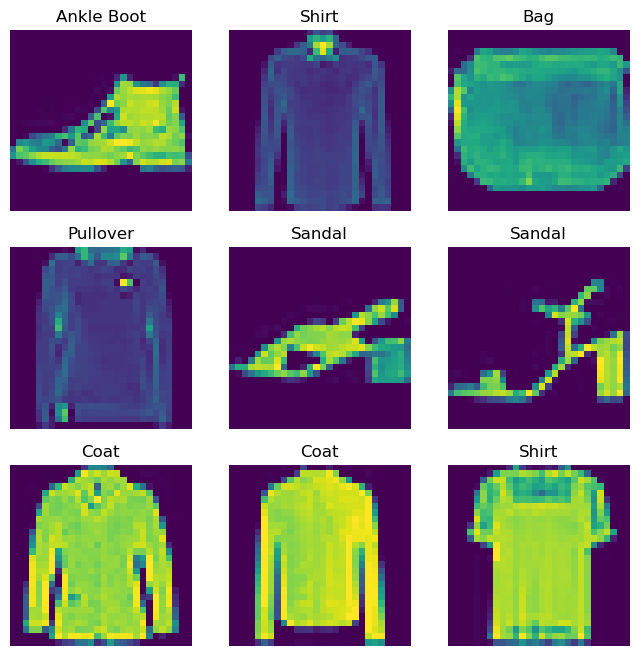

In [16]:
#Visualizing 9 random examples
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    imge, labele = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[labele])
    plt.axis("off")
    plt.imshow(imge.squeeze())
plt.show()

In [5]:
#Splitting our data into batch sizes
mnist_batch_size = 256

mnist_train_iter = torch.utils.data.DataLoader(mnist_train,mnist_batch_size,shuffle=True,num_workers=4,pin_memory=True)
mnist_test_iter = torch.utils.data.DataLoader(mnist_test,mnist_test.__len__(),shuffle=False,num_workers=4,pin_memory=True)

In [42]:
#Creating the model and initializing the weights (logit - logistic regression)
logit_net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))


#Initializing weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

logit_net.apply(init_weights)

#Specifying cross entropy loss
logit_loss = nn.CrossEntropyLoss(reduction='none')

#Specifying Stochastic Gradient Descent trainer
logit_trainer = torch.optim.SGD(logit_net.parameters(), lr=0.1)

In [43]:
logit_training = Gradient_Img_Trainer(logit_net, mnist_train_iter, logit_loss, logit_trainer, mnist_test_iter)
logit_training.Train(50)

-------------------
1th epoch
Loss: 2368.9462890625
In-sample error: tensor(0.7871)
-------------------
2th epoch
Loss: 2143.240966796875
In-sample error: tensor(0.4727)
-------------------
3th epoch
Loss: 1985.4095458984375
In-sample error: tensor(0.4736)
-------------------
4th epoch
Loss: 1840.089599609375
In-sample error: tensor(0.3662)
-------------------
5th epoch
Loss: 1715.36328125
In-sample error: tensor(0.3672)
-------------------
6th epoch
Loss: 1652.0694580078125
In-sample error: tensor(0.3574)
-------------------
7th epoch
Loss: 1585.7110595703125
In-sample error: tensor(0.3594)
-------------------
8th epoch
Loss: 1512.7890625
In-sample error: tensor(0.3545)
-------------------
9th epoch
Loss: 1452.01708984375
In-sample error: tensor(0.3516)
-------------------
10th epoch
Loss: 1378.7506103515625
In-sample error: tensor(0.3262)
-------------------
11th epoch
Loss: 1334.910888671875
In-sample error: tensor(0.3340)
-------------------
12th epoch
Loss: 1308.1683349609375
In-s

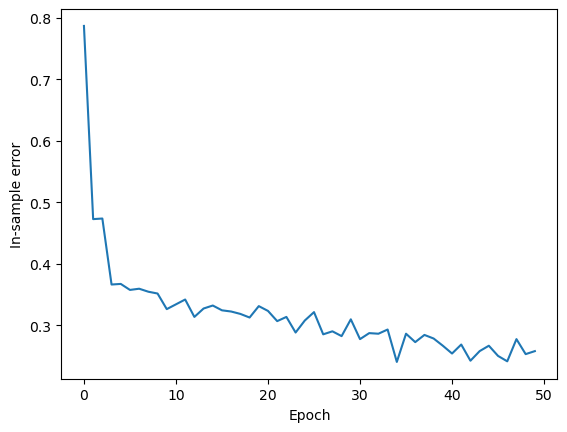

In [44]:
logit_training.result.plot_error()

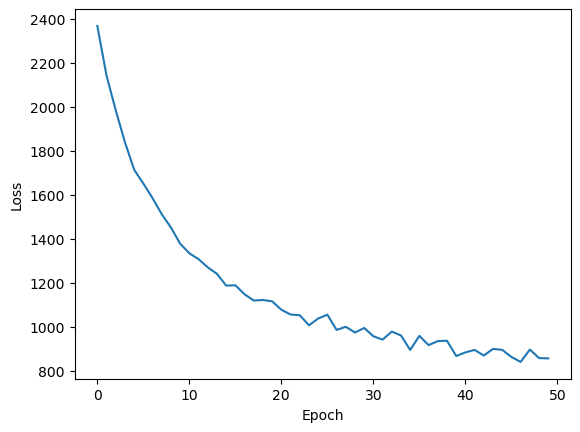

In [45]:
logit_training.result.plot_loss()

In [46]:
logit_training.Test()

Out-of-sample error: tensor(0.2782)


In [45]:
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [6]:
#Perceptron initiation

MLP = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

MLP.apply(init_weights)

MLP_loss = nn.CrossEntropyLoss(reduction='none')

MLP_trainer = torch.optim.SGD(MLP.parameters(),lr = 0.1)

In [7]:
MLP_Training = Gradient_Img_Trainer(MLP, mnist_train_iter, MLP_loss, MLP_trainer, mnist_test_iter)
MLP_Training.Train(50)

-------------------
1th epoch
Loss: 590.0859985351562
In-sample error: tensor(0.8594)
-------------------
2th epoch
Loss: 588.3753662109375
In-sample error: tensor(0.8594)
-------------------
3th epoch
Loss: 587.9127197265625
In-sample error: tensor(0.8281)
-------------------
4th epoch
Loss: 585.8758544921875
In-sample error: tensor(0.8398)
-------------------
5th epoch
Loss: 583.5458984375
In-sample error: tensor(0.8203)
-------------------
6th epoch
Loss: 581.2896728515625
In-sample error: tensor(0.7305)
-------------------
7th epoch
Loss: 578.6809692382812
In-sample error: tensor(0.7031)
-------------------
8th epoch
Loss: 576.4505615234375
In-sample error: tensor(0.7070)
-------------------
9th epoch
Loss: 574.5492553710938
In-sample error: tensor(0.7422)
-------------------
10th epoch
Loss: 574.2978515625
In-sample error: tensor(0.7969)
-------------------
11th epoch
Loss: 567.6940307617188
In-sample error: tensor(0.7773)
-------------------
12th epoch
Loss: 566.9234619140625
In-

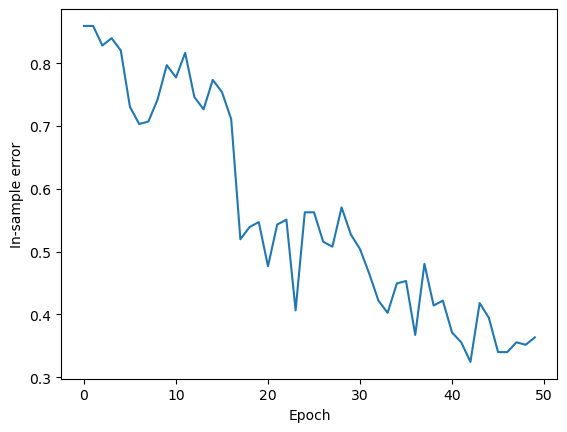

In [8]:
MLP_Training.result.plot_error()

In [9]:
MLP_Training.Test()

Out-of-sample error: tensor(0.3932)


In [49]:
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [50]:
#Running a logistic regression with weight decay

Wd_net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

Wd_net.apply(init_weights)

Wd_loss = nn.CrossEntropyLoss(reduction='none')

Weight_decay = 10

Wd_trainer = torch.optim.SGD([
    {"params":Wd_net[1].weight,'weight decay':Weight_decay},
    {"params":Wd_net[1].bias}],lr = 0.1)

-------------------
1th epoch
Loss: 584.7893581153643
In-sample error: tensor(0.7305)
-------------------
2th epoch
Loss: 527.3086460813738
In-sample error: tensor(0.5156)
-------------------
3th epoch
Loss: 491.0728709725405
In-sample error: tensor(0.5547)
-------------------
4th epoch
Loss: 478.96862840886615
In-sample error: tensor(0.4531)
-------------------
5th epoch
Loss: 433.8595048331514
In-sample error: tensor(0.4062)
-------------------
6th epoch
Loss: 429.41618486659286
In-sample error: tensor(0.4258)
-------------------
7th epoch
Loss: 389.47406380225743
In-sample error: tensor(0.3594)
-------------------
8th epoch
Loss: 371.77592651903035
In-sample error: tensor(0.3594)
-------------------
9th epoch
Loss: 363.27021157943517
In-sample error: tensor(0.3555)
-------------------
10th epoch
Loss: 342.4757699856971
In-sample error: tensor(0.3359)
-------------------
11th epoch
Loss: 323.191480133262
In-sample error: tensor(0.3125)
-------------------
12th epoch
Loss: 316.4208293

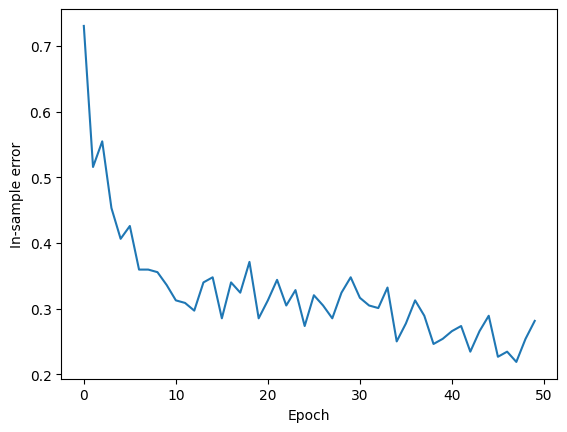

In [51]:
Wd_Training = Gradient_Img_Trainer(Wd_net, mnist_train_iter, Wd_loss, Wd_trainer, mnist_test_iter)
Wd_Training.Train(50)

In [52]:
Wd_Training.Test()

Out-of-sample error: tensor(0.2834)


In [ ]:
'''--------------------------------------------------------'''

In [22]:
#MLP with Drop-out

Dropout_net = nn.Sequential(nn.Flatten(),
                            nn.Linear(784,256),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(256,256),
                            nn.ReLU(0.5),
                            nn.Dropout(0.5),
                            nn.Linear(256,10)
                            )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

Dropout_net.apply(init_weights)

Dropout_loss = nn.CrossEntropyLoss(reduction='none')
Dropout_trainer = torch.optim.SGD(Dropout_net.parameters(), lr = 0.5)

-------------------
1th epoch
Loss: 589.6979523499665
In-sample error: tensor(0.9062)
-------------------
2th epoch
Loss: 588.5107049106989
In-sample error: tensor(0.8633)
-------------------
3th epoch
Loss: 588.4913904371328
In-sample error: tensor(0.8711)
-------------------
4th epoch
Loss: 588.9923198880233
In-sample error: tensor(0.8906)
-------------------
5th epoch
Loss: 588.4681541625126
In-sample error: tensor(0.8594)
-------------------
6th epoch
Loss: 588.7656427691295
In-sample error: tensor(0.8867)
-------------------
7th epoch
Loss: 588.2890994559613
In-sample error: tensor(0.8867)
-------------------
8th epoch
Loss: 587.5615559943494
In-sample error: tensor(0.8398)
-------------------
9th epoch
Loss: 589.4670929245061
In-sample error: tensor(0.8867)
-------------------
10th epoch
Loss: 587.4385176212947
In-sample error: tensor(0.8984)
-------------------
11th epoch
Loss: 586.0677062558009
In-sample error: tensor(0.8789)
-------------------
12th epoch
Loss: 586.53205207896

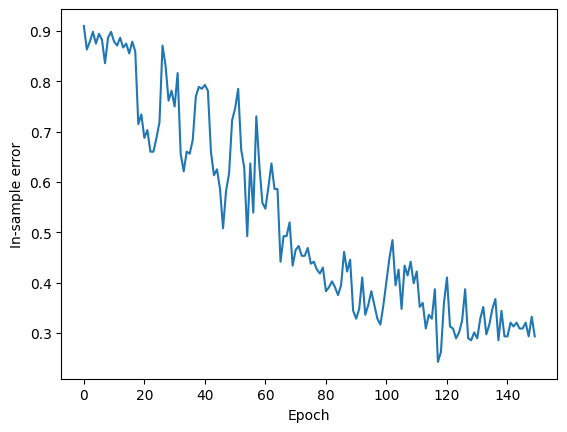

In [23]:
#Training with Drop-out
Dropout_training = Gradient_Img_Trainer(Dropout_net,mnist_train_iter,Dropout_loss,
                                        Dropout_trainer,mnist_test_iter)
Dropout_training.Train(150)

In [24]:
#Testing
Dropout_training.Test()

Out-of-sample error: tensor(0.2959)


In [ ]:
'''--------------------------------------------------------'''

In [34]:
#Basic CNN implementation
CNN = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120), nn.ReLU(),
    nn.Linear(120,84), nn.ReLU(),
    nn.Linear(84,10))

def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight)

CNN.apply(xavier_init)


CNN_loss = nn.CrossEntropyLoss(reduction='none')

CNN_trainer = torch.optim.SGD(CNN.parameters(),lr = 0.3)

-------------------
1th epoch
In-sample error: tensor(0.8760)
-------------------
2th epoch
In-sample error: tensor(0.6973)
-------------------
3th epoch
In-sample error: tensor(0.6807)
-------------------
4th epoch
In-sample error: tensor(0.6777)
-------------------
5th epoch
In-sample error: tensor(0.7012)
-------------------
6th epoch
In-sample error: tensor(0.8066)
-------------------
7th epoch
In-sample error: tensor(0.9033)
-------------------
8th epoch
In-sample error: tensor(0.8291)
-------------------
9th epoch
In-sample error: tensor(0.8623)
-------------------
10th epoch
In-sample error: tensor(0.8213)
-------------------
11th epoch
In-sample error: tensor(0.7695)
-------------------
12th epoch
In-sample error: tensor(0.7734)
-------------------
13th epoch
In-sample error: tensor(0.7236)
-------------------
14th epoch
In-sample error: tensor(0.7451)
-------------------
15th epoch
In-sample error: tensor(0.7266)
-------------------
16th epoch
In-sample error: tensor(0.7080)
-

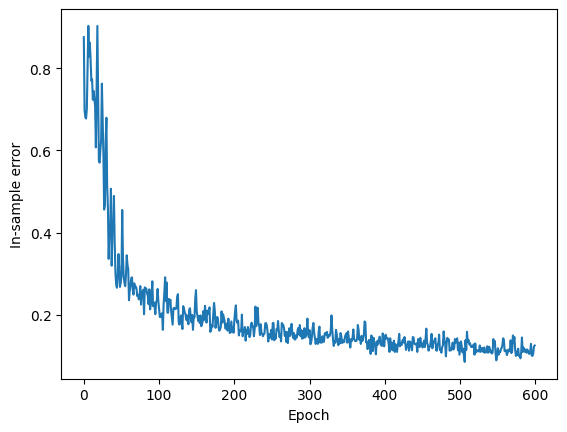

In [35]:
#Training of our CNN
CNN_training = Gradient_Img_Trainer(CNN,mnist_train_iter,CNN_loss,CNN_trainer,mnist_test_iter)
CNN_training.Train(600, print_loss=False)

In [37]:
#Testing our model (we'd normally use validation set here to avoid overfitting to test data)
CNN_training.Test()

Out-of-sample error: tensor(0.1476)


In [ ]:
'''--------------------------------------------------------'''

In [57]:
#Running a CNN with learning rate decay
CNN2 = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120), nn.ReLU(),nn.Dropout(0.2),
    nn.Linear(120,84), nn.ReLU(),nn.Dropout(0.2),
    nn.Linear(84,10))

def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight)

CNN2.apply(xavier_init)


CNN2_loss = nn.CrossEntropyLoss(reduction='none')

CNN2_trainer = torch.optim.SGD(CNN2.parameters(),lr = 0.3)

CNN2_scheduler = torch.optim.lr_scheduler.MultiStepLR(CNN2_trainer,milestones=[50,100,200,400,600,700],gamma=0.8)

-------------------
1th epoch
In-sample error: tensor(0.8672)
-------------------
2th epoch
In-sample error: tensor(0.8174)
-------------------
3th epoch
In-sample error: tensor(0.8291)
-------------------
4th epoch
In-sample error: tensor(0.7500)
-------------------
5th epoch
In-sample error: tensor(0.8291)
-------------------
6th epoch
In-sample error: tensor(0.7734)
-------------------
7th epoch
In-sample error: tensor(0.6953)
-------------------
8th epoch
In-sample error: tensor(0.7188)
-------------------
9th epoch
In-sample error: tensor(0.8145)
-------------------
10th epoch
In-sample error: tensor(0.8447)
-------------------
11th epoch
In-sample error: tensor(0.6416)
-------------------
12th epoch
In-sample error: tensor(0.6211)
-------------------
13th epoch
In-sample error: tensor(0.7539)
-------------------
14th epoch
In-sample error: tensor(0.6904)
-------------------
15th epoch
In-sample error: tensor(0.6338)
-------------------
16th epoch
In-sample error: tensor(0.6504)
-

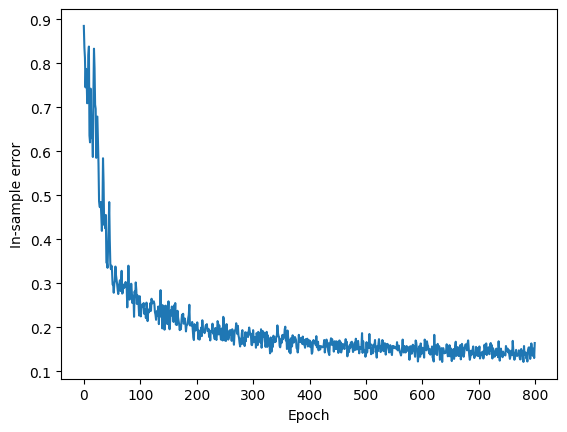

In [58]:
#Training our model with decaying learning rate scheduled at 50'th and 600'th epoch
CNN2_training = Gradient_Img_Trainer(CNN2,mnist_train_iter,CNN2_loss,CNN2_trainer,mnist_test_iter,CNN2_scheduler)
CNN2_training.Train(800, print_loss=False)

In [59]:
CNN2_training.Test()

Out-of-sample error: tensor(0.1396)


In [ ]:
'''--------------------------------------------------------'''

In [ ]:
##CUDA

In [6]:
#For our CNN implementation we'll be significantly increasing our batch sizes
mnist_batch_size = 1024

mnist_train_iter = torch.utils.data.DataLoader(mnist_train,mnist_batch_size,shuffle=True,pin_memory=True,pin_memory_device='cuda:0')
mnist_test_iter = torch.utils.data.DataLoader(mnist_test,mnist_test.__len__(),shuffle=False,pin_memory=True,pin_memory_device='cuda:0')

In [8]:
#Experimenting with convolutions and batch normalization
CNN3 = nn.Sequential(
    nn.Conv2d(1,16,kernel_size=5,padding=2),nn.BatchNorm2d(16),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(16,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU(),
    nn.Conv2d(64,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU(),
    nn.Conv2d(64,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(784,120),nn.BatchNorm1d(120), nn.ReLU(),
    nn.Linear(120,84),nn.BatchNorm1d(84),nn.ReLU(),
    nn.Linear(84,10))

In [51]:
#Running a CNN with learning rate decay
def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight).cuda()

CNN3.apply(xavier_init)


CNN3_loss = nn.CrossEntropyLoss(reduction='none')

CNN3_trainer = torch.optim.SGD(CNN3.parameters(),lr = 0.3)

CNN3_scheduler = torch.optim.lr_scheduler.MultiStepLR(CNN3_trainer,milestones=[50,100,200,400,600,700],gamma=0.8)

In [52]:
#Training the model
CNN3_training = Gradient_Img_Trainer(CNN3,mnist_train_iter,CNN3_loss,CNN3_trainer,mnist_test_iter,CNN3_scheduler,'cuda:0')

CNN3_training.Train(800,print_loss=False)

-------------------
1th epoch
In-sample error: tensor(0.6152, device='cuda:0')
-------------------
2th epoch
In-sample error: tensor(0.4863, device='cuda:0')
-------------------
3th epoch
In-sample error: tensor(0.3672, device='cuda:0')
-------------------
4th epoch
In-sample error: tensor(0.3232, device='cuda:0')
-------------------
5th epoch
In-sample error: tensor(0.2441, device='cuda:0')
-------------------
6th epoch
In-sample error: tensor(0.2148, device='cuda:0')
-------------------
7th epoch
In-sample error: tensor(0.2236, device='cuda:0')
-------------------
8th epoch
In-sample error: tensor(0.2227, device='cuda:0')
-------------------
9th epoch
In-sample error: tensor(0.2217, device='cuda:0')
-------------------
10th epoch
In-sample error: tensor(0.2051, device='cuda:0')
-------------------
11th epoch
In-sample error: tensor(0.1992, device='cuda:0')
-------------------
12th epoch
In-sample error: tensor(0.2051, device='cuda:0')
-------------------
13th epoch
In-sample error: t

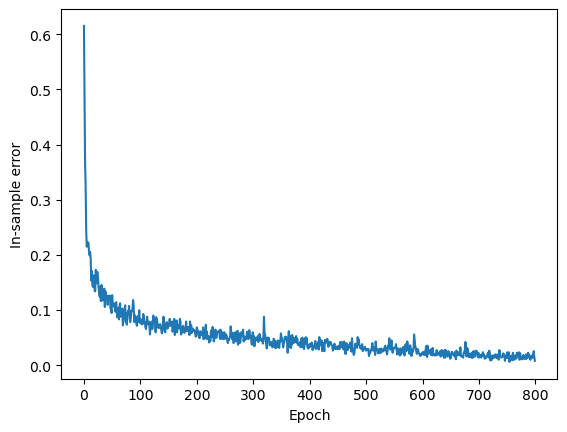

In [54]:
CNN3_training.result.plot_error()

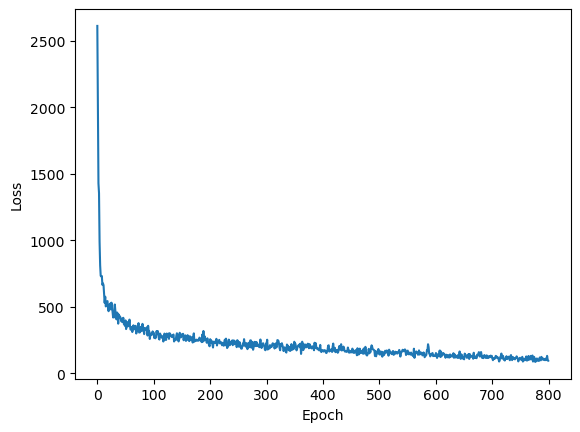

In [55]:
CNN3_training.result.plot_loss()

In [56]:
#We're starting to see promising results
CNN3_training.Test()

Out-of-sample error: tensor(0.0852, device='cuda:0')


In [18]:
##Testing whether we can run code remotely on server:
CNN4 = nn.Sequential(
    nn.Conv2d(1,16,kernel_size=5,padding=2),nn.BatchNorm2d(16),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(16,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU(),
    nn.Conv2d(64,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU(),
    nn.Conv2d(64,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(784,120),nn.BatchNorm1d(120), nn.ReLU(),
    nn.Linear(120,84),nn.BatchNorm1d(84),nn.ReLU(),
    nn.Linear(84,10))

In [19]:
def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight).cuda()

CNN4.apply(xavier_init)


CNN4_loss = nn.CrossEntropyLoss(reduction='none')

CNN4_trainer = torch.optim.SGD(CNN4.parameters(),lr = 0.3)

CNN4_scheduler = torch.optim.lr_scheduler.MultiStepLR(CNN4_trainer,milestones=[50,100,200,400,600,700],gamma=0.8)

In [20]:
CNN4_training = Gradient_Img_Trainer(CNN4,mnist_train_iter,CNN4_loss,CNN4_trainer,mnist_test_iter,CNN4_scheduler,'cuda:0')

CNN4_training.Train(50,print_loss=False)

-------------------
1th epoch
In-sample error: tensor(0.6133, device='cuda:0')
-------------------
2th epoch
In-sample error: tensor(0.5059, device='cuda:0')
-------------------
3th epoch
In-sample error: tensor(0.4248, device='cuda:0')
-------------------
4th epoch
In-sample error: tensor(0.2979, device='cuda:0')
-------------------
5th epoch
In-sample error: tensor(0.2646, device='cuda:0')
-------------------
6th epoch
In-sample error: tensor(0.2637, device='cuda:0')
-------------------
7th epoch
In-sample error: tensor(0.2344, device='cuda:0')
-------------------
8th epoch
In-sample error: tensor(0.1875, device='cuda:0')
-------------------
9th epoch
In-sample error: tensor(0.2246, device='cuda:0')
-------------------
10th epoch
In-sample error: tensor(0.1982, device='cuda:0')
-------------------
11th epoch
In-sample error: tensor(0.2080, device='cuda:0')
-------------------
12th epoch
In-sample error: tensor(0.2061, device='cuda:0')
-------------------
13th epoch
In-sample error: t

In [12]:
#Success!! The above model has been run from a laptop on a server set up on a remote device

In [8]:
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [36]:
#Creating a Residual Network with self created ResidualBlock class
ResNet1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=1,padding = 3),nn.BatchNorm2d(64),nn.ReLU(),
              nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
              ResidualBlock(64,64),
              ResidualBlock(64,128),
              ResidualBlock(128,256),
              nn.AdaptiveAvgPool2d((1,1)),
              nn.Flatten(),
              nn.Linear(256,10))

In [41]:
#Defining the parameters
def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight).cuda()

ResNet1.apply(xavier_init)


ResNet1_loss = nn.CrossEntropyLoss(reduction='none')

ResNet1_trainer = torch.optim.SGD(ResNet1.parameters(),lr = 0.1)

ResNet1_scheduler = torch.optim.lr_scheduler.MultiStepLR(ResNet1_trainer,milestones=[600,700,800,1000,1200],gamma=0.5)

In [42]:
#Training our model
ResNet1_Training = Gradient_Img_Trainer(ResNet1,mnist_train_iter,ResNet1_loss,ResNet1_trainer,mnist_test_iter,scheduler=ResNet1_scheduler,device='cuda:0')

ResNet1_Training.Train(1400,print_loss=False)

-------------------
1th epoch
In-sample error: tensor(0.2197, device='cuda:0')
-------------------
2th epoch
In-sample error: tensor(0.1377, device='cuda:0')
-------------------
3th epoch
In-sample error: tensor(0.1094, device='cuda:0')
-------------------
4th epoch
In-sample error: tensor(0.0918, device='cuda:0')
-------------------
5th epoch
In-sample error: tensor(0.0830, device='cuda:0')
-------------------
6th epoch
In-sample error: tensor(0.0566, device='cuda:0')
-------------------
7th epoch
In-sample error: tensor(0.0615, device='cuda:0')
-------------------
8th epoch
In-sample error: tensor(0.0605, device='cuda:0')
-------------------
9th epoch
In-sample error: tensor(0.0498, device='cuda:0')
-------------------
10th epoch
In-sample error: tensor(0.0547, device='cuda:0')
-------------------
11th epoch
In-sample error: tensor(0.0371, device='cuda:0')
-------------------
12th epoch
In-sample error: tensor(0.0498, device='cuda:0')
-------------------
13th epoch
In-sample error: t

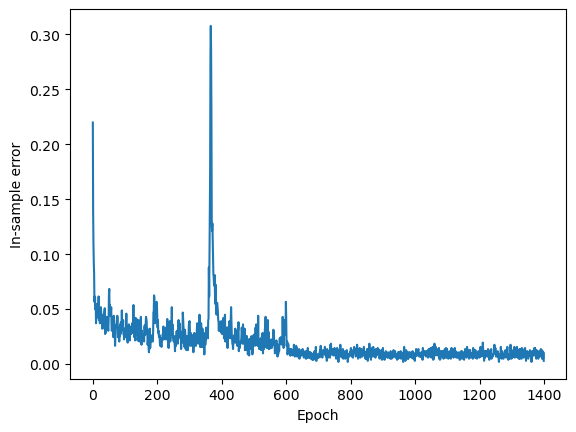

In [43]:
ResNet1_Training.result.plot_error()

In [44]:
ResNet1_Training.Test()

Out-of-sample error: tensor(0.0716)


In [ ]:
'''--------------------------------------------------------'''

In [21]:
#Let's experiment with the set-up and parameters of our network
ResNet2 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=1,padding = 3),nn.BatchNorm2d(64),nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
                        ResidualBlock(64,64),
                        ResidualBlock(64,64),
                        ResidualBlock(64,128),
                        ResidualBlock(128,128),
                        ResidualBlock(128,256),
                        ResidualBlock(256,128),
                        nn.AdaptiveAvgPool2d((1,1)),
                        nn.Flatten(),
                        nn.Linear(256,10))

In [8]:
#Defining the parameters
def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight).cuda()

ResNet2.apply(xavier_init)


ResNet2_loss = nn.CrossEntropyLoss(reduction='none')

ResNet2_trainer = torch.optim.SGD(ResNet2.parameters(),lr = 0.1)

ResNet2_scheduler = torch.optim.lr_scheduler.MultiStepLR(ResNet2_trainer,milestones=[200,1000,1500],gamma=0.5)

In [9]:
ResNet2_Training = Gradient_Img_Trainer(ResNet2,mnist_train_iter,ResNet2_loss,ResNet2_trainer,mnist_test_iter,ResNet2_scheduler,'cuda:0')

ResNet2_Training.Train(2000,print_loss=False)

-------------------
1th epoch
In-sample error: tensor(0.7129, device='cuda:0')
-------------------
2th epoch
In-sample error: tensor(0.5098, device='cuda:0')
-------------------
3th epoch
In-sample error: tensor(0.4658, device='cuda:0')
-------------------
4th epoch
In-sample error: tensor(0.4072, device='cuda:0')
-------------------
5th epoch
In-sample error: tensor(0.3564, device='cuda:0')
-------------------
6th epoch
In-sample error: tensor(0.3486, device='cuda:0')
-------------------
7th epoch
In-sample error: tensor(0.3672, device='cuda:0')
-------------------
8th epoch
In-sample error: tensor(0.3213, device='cuda:0')
-------------------
9th epoch
In-sample error: tensor(0.3779, device='cuda:0')
-------------------
10th epoch
In-sample error: tensor(0.3154, device='cuda:0')
-------------------
11th epoch
In-sample error: tensor(0.3018, device='cuda:0')
-------------------
12th epoch
In-sample error: tensor(0.3105, device='cuda:0')
-------------------
13th epoch
In-sample error: t

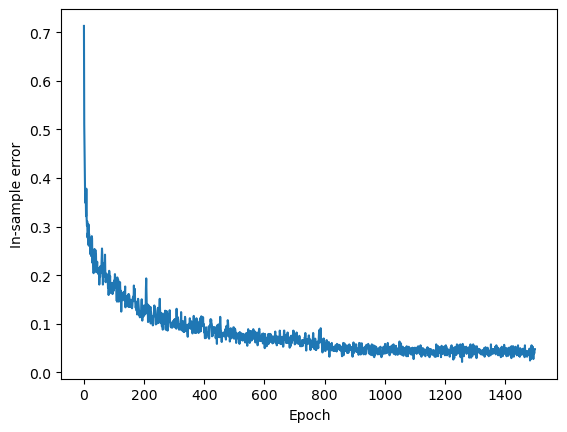

In [22]:
ResNet2_Training.result.plot_error()

In [10]:
ResNet2_Training.Test()

Out-of-sample error: tensor(0.0814)


In [12]:
ResNet2_Training.result.missclass()

tensor([0.1622, 0.0197, 0.1450, 0.1130, 0.1314, 0.0184, 0.3120, 0.0369, 0.0184,
        0.0430])

In [ ]:
'''--------------------------------------------------------'''

In [56]:
#DenseNet
b1 = Conv_Block(64,64)
b2 = Conv_Block(64,128)
b3 = Conv_Block(128,256)

denseblocks = nn.Sequential(b1,b2,b3)

DenseNet1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=1,padding = 3),nn.BatchNorm2d(64),nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
                        DenseBlock(denseblocks),nn.BatchNorm2d(256),nn.ReLU(),
                        nn.AdaptiveMaxPool2d((1,1)),
                        nn.Flatten(),
                        nn.Linear(256,10))

In [57]:
#Defining the parameters
def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight).cuda()

DenseNet1.apply(xavier_init)


DenseNet1_loss = nn.CrossEntropyLoss(reduction='none')

DenseNet1_trainer = torch.optim.SGD(DenseNet1.parameters(),lr = 0.1)

DenseNet1_scheduler = torch.optim.lr_scheduler.MultiStepLR(DenseNet1_trainer,milestones=[200,1000,1500],gamma=0.5)

In [58]:
DenseNet1_Training = Gradient_Img_Trainer(DenseNet1,mnist_train_iter,DenseNet1_loss,DenseNet1_trainer,mnist_test_iter,DenseNet1_scheduler,'cuda:0')

DenseNet1_Training.Train(10,print_loss=False)

-------------------
1th epoch
first block:Sequential(
  (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
first output:tensor([[[[-2.8424e-02,  1.7157e-02,  1.2468e-01,  ..., -1.1816e-01,
           -3.4202e-02, -1.8832e-02],
          [-9.8722e-02, -7.6892e-03, -4.4714e-02,  ..., -2.8171e-01,
           -1.0592e-01, -6.2080e-02],
          [-8.4512e-02, -1.0147e-01, -1.2493e-01,  ..., -1.7957e-01,
           -1.1133e-01, -5.4811e-03],
          ...,
          [-7.2234e-02, -8.8587e-02, -2.1347e-01,  ..., -3.1058e-01,
           -2.9761e-01, -9.4764e-02],
          [-7.3183e-02, -1.0344e-01, -2.2819e-01,  ..., -2.4706e-01,
           -2.3370e-01, -9.5238e-02],
          [-6.4417e-02, -1.6774e-01, -2.1726e-01,  ..., -1.3573e-01,
           -2.0580e-01, -1.4818e-01]],

         [[-3.9827e-02, -1.0566e-01, -1.6437e-01,  ..., -6.0962e-02,
            1.7843e-02, -5.01

RuntimeError: running_mean should contain 128 elements not 64